In [1]:
import heeps

### 1. Create a config dictionary with your simulation parameters in read_config

In [2]:
conf = dict(
    dir_current = '$HOME/heeps_metis',  # specify a directory
    nframes = 10,                       # number of SCAO phase screens selected
    cpu_count = 10,                     # number of physical CPUs
    f_phase = 'wavefront/COMPASS_201810_RandomWind_100screens_meters.fits',
    f_pupil = 'pupil/ELT_fullM1.fits',  # entrance pupil file
)
conf = heeps.config.read_config(verbose=False, **conf)

### 2. Update config parameters. The following parameters will be updated to match the selected spectral band:
lam, pscale, flux_star, flux_bckg, npupil, beam_ratio, ndet, hfov, hfov_lamD

In [3]:
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf) 

Simulation config: band=L, mode=RAVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, beam_ratio=0.2568
   ravc_calc=True, ravc_t=0.7608, ravc_r=0.6213
   npupil=285, pscale=5.47 mas, lam=3.8112E-06 m
   hfov=1.1 arcsec (-> ndet=403, 51.74 lam/D)



### 3. Load entrance pupil, and create 'wavefront' object

In [4]:
wf = heeps.pupil.pupil(savefits=True, verbose=True, **conf)

Load pupil from 'ELT_fullM1.fits'


### 4. Load wavefront errors

In [5]:
phase_screens, amp_screens, tiptilts, misaligns = heeps.wavefront.load_errors(
    verbose=True, **conf)

Load phase screens from 'COMPASS_201810_RandomWind_100screens_meters.fits'
   nscreens=10 (nframes=10, nstep=1)


### 5. Propagate one frame of off-axis psf (=planet)

In [6]:
_ = heeps.wavefront.propagate_one(wf, onaxis=False, savefits=True, 
    verbose=True, **conf)

Create single off-axis PSF
   apply ring apodizer: ravc_t=0.7608, ravc_r=0.6213
   apply Lyot stop: ls_int=0.6517, ls_ext=0.9696, ls_spi=0.0477
   extract PSF on the detector: ndet=403


### 6. Propagate cube of on-axis psfs (=star)

In [7]:
_ = heeps.wavefront.propagate_cube(wf, phase_screens=phase_screens,
    amp_screens=amp_screens, tiptilts=tiptilts, misaligns=misaligns, 
    onaxis=True, savefits=True, verbose=True, **conf)

Create on-axis PSF cube
   2022-03-15 13:27:01, e2e simulation using 10 cores
   2022-03-15 13:27:07, completed in 5.72 seconds


### 7. Produce a 5-sigma sensitivity (contrast) curve

In [8]:
sep1, sen1 = heeps.contrast.adi_one(savepsf=True, savefits=True, 
    verbose=True, **conf)

Load PSFs for ADI
   mode=RAVC, band=L
   ncube=10, ndet=403
   pscale=5.47 mas, dit=0.3 s
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-15 13:27:08
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : median_sub, FWHM = 3.1445777905356147, # BRANCHES = 1, SIGMA = 5, STARPHOT = 100000000000.0
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Finished the throughput calculation
Running time:  0:00:05.723400
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [9]:
# now, add star flux + background flux + photon noise
conf['add_bckg'] = True
sep2, sen2 = heeps.contrast.adi_one(savepsf=True, savefits=True, 
    verbose=True, **conf)

Load PSFs for ADI
   mode=RAVC, band=L
   ncube=10, ndet=403
   pscale=5.47 mas, dit=0.3 s
   offaxis_trans=0.2802, mask_trans=0.8532,
   mag=5, dit=0.300
   star_signal=2.70E+08, bckg_noise=6.37E+03
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-15 13:27:15
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : median_sub, FWHM = 3.144577767217157, # BRANCHES = 1, SIGMA = 5, STARPHOT = 100000000000.0
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Finished the throughput calculation
Running time:  0:00:05.881022
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


### 8. Create a figure 

In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
%matplotlib inline

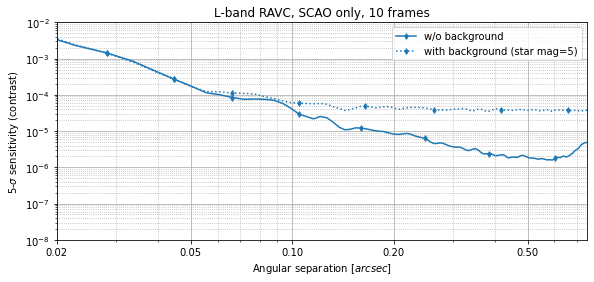

In [11]:
savename = 'ADI_contrast_curve.png'
plt.figure(figsize=(9.5, 4))
plt.grid(True), plt.grid(which='minor', linestyle=':')
plt.loglog(), plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.xlabel('Angular separation $[arcsec]$')
plt.ylabel('5-$\sigma$ sensitivity (contrast)')
plt.title('%s-band %s, SCAO only, %s frames'%(conf['band'], conf['mode'], conf['nframes']))
plt.plot(sep1, sen1, 'C0', label='w/o background', marker='d', markevery=0.12, markersize=4)
plt.plot(sep2, sen2, 'C0:', label='with background (star mag=5)', marker='d', markevery=0.12, markersize=4)
plt.legend()
plt.xlim(0.02, 0.75)
plt.ylim(1e-8,1e-2)
plt.xticks([0.02, 0.05, 0.1, 0.2, 0.5])
plt.savefig('%s/%s'%(conf['dir_output'], savename), dpi=300, transparent=True);